# Manns Lab data - Loading MAIN and PILOT data

Initial data exploration of both MAIN and PILOT data.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import spearmanr, pearsonr
import warnings

import manns_lab_support as sup

warnings.filterwarnings("ignore")

In [2]:
MAIN_ANNOTATIONS_PATH = "../data/manns_lab/MAIN/annotations_main_lt_v21_Sc11_AIMsplit3.tsv"
MAIN_DATA_PATH = "../data/manns_lab/MAIN/DA-F08.4_-SEC-pass_v06Sc_ion_LibPGQVal1perc_precdLFQdefFull_prot_preprSc03.tsv"

PILOT_ANNOTATIONS_PATH = "../data/manns_lab/PILOT/2023_sample annotation_PILOTcohorts combined_v21_Sc06.tsv"
PILOT_DATA_PATH = "../data/manns_lab/PILOT/DAP-F03.4_-SEC-pass_v06Sc_ion_LibPGQVal1perc_precdLFQdefFull_protein_intensities.tsv"

In [3]:
main_adata = sup.load_main_data(MAIN_DATA_PATH, MAIN_ANNOTATIONS_PATH)
main_adata = sup.preprocess(main_adata)

pilot_adata = sup.load_pilot_data(PILOT_DATA_PATH, PILOT_ANNOTATIONS_PATH)
pilot_adata = sup.preprocess(pilot_adata)

input: (5045, 2703)
sc.pp.filter_genes: (5045, 2703)
sc.pp.filter_cells: (5045, 2703)
filter: (4566, 2018)
input: (461, 3306)
sc.pp.filter_genes: (461, 3305)
sc.pp.filter_cells: (461, 3305)
filter: (454, 2963)


In [4]:
combined_adata = sup.combine_PILOT_and_MAIN(main_adata, pilot_adata)

Nr. patients | main: 4566, pilot: 454, in both: 447
Nr. proteins | main: 2018, pilot: 2963, in both: 1783


In [5]:
sup.print_combined_summary(combined_adata)

Percentage non-missing intensity entries for patients in both PILOT and MAIN (patients: 447):
  2018 unique proteins (all those in MAIN):      76.32%
  1783 unique proteins (in both MAIN and PILOT): 86.38%

Percentage non-missing intensity entries using MAIN layout (patients: 4566, proteins: 2018)
  MAIN:     69.66%
  PILOT:    7.47%
  combined: 71.28%


In [6]:
combined_adata.X = combined_adata.layers["MAIN"].copy()
sup.correct_batch(combined_adata)
combined_adata.layers["MAIN_corrected"] = combined_adata.X.copy()

combined_adata.X = combined_adata.layers["PILOT"].copy()
sup.correct_batch(combined_adata)
combined_adata.layers["PILOT_corrected"] = combined_adata.X.copy()

Text(619.9949494949494, 0.5, 'PILOT intensity')

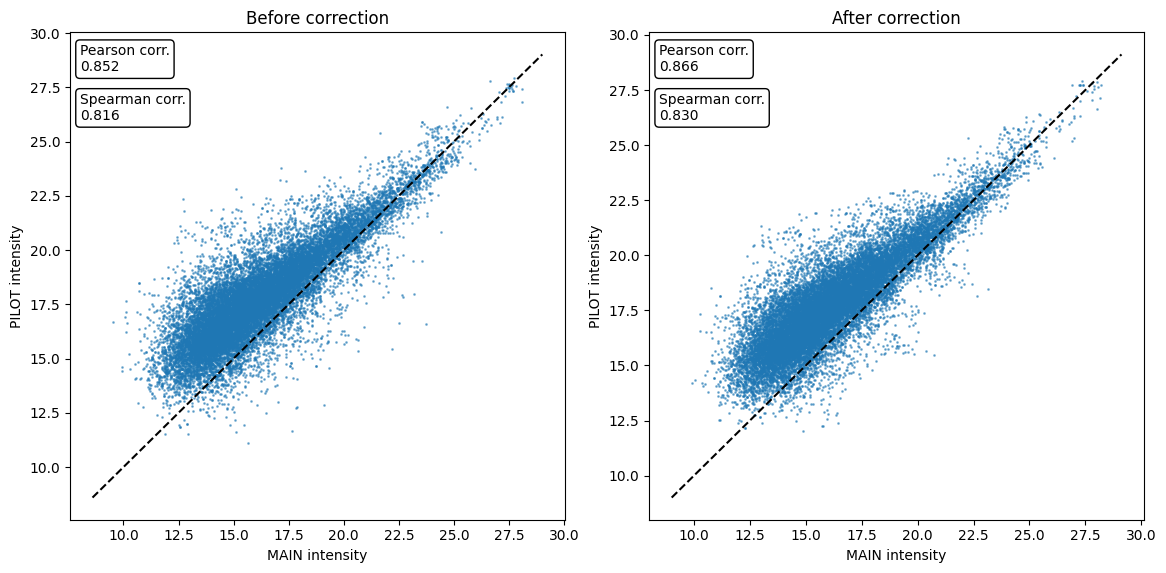

In [7]:
N = 20_000

overlap_filter = np.logical_and(~np.isnan(combined_adata.layers["PILOT"]), ~np.isnan(combined_adata.layers["MAIN"]))

np.random.seed(0)
ns = np.random.choice(np.sum(overlap_filter), size=N)

fig, axes = plt.subplots(figsize=(12, 6), ncols=2)
fig.tight_layout(pad=3)

# before batch correction
ax = axes[0]

intensity_MAIN = combined_adata.layers["MAIN"][overlap_filter]
intensity_PILOT = combined_adata.layers["PILOT"][overlap_filter]

intensity_MAIN = intensity_MAIN[ns]
intensity_PILOT = intensity_PILOT[ns]

pearson = pearsonr(intensity_MAIN, intensity_PILOT)
ax.text(0.02, 0.92, f"Pearson corr.\n{pearson[0]:.3f}", fontsize=10, bbox=dict(facecolor="white", edgecolor="black", boxstyle="round"), transform=ax.transAxes)

spearman = spearmanr(intensity_MAIN, intensity_PILOT)
ax.text(0.02, 0.82, f"Spearman corr.\n{spearman[0]:.3f}", fontsize=10, bbox=dict(facecolor="white", edgecolor="black", boxstyle="round"), transform=ax.transAxes)

ax.scatter(intensity_MAIN, intensity_PILOT, s=1, alpha=0.5)
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, color="black", linestyle="--")
ax.set_title(f"Before correction")
ax.set_xlabel("MAIN intensity")
ax.set_ylabel("PILOT intensity")

# after batch correction
ax = axes[1]

intensity_MAIN = combined_adata.layers["MAIN_corrected"][overlap_filter]
intensity_PILOT = combined_adata.layers["PILOT_corrected"][overlap_filter]

intensity_MAIN = intensity_MAIN[ns]
intensity_PILOT = intensity_PILOT[ns]

pearson = pearsonr(intensity_MAIN, intensity_PILOT)
ax.text(0.02, 0.92, f"Pearson corr.\n{pearson[0]:.3f}", fontsize=10, bbox=dict(facecolor="white", edgecolor="black", boxstyle="round"), transform=ax.transAxes)

spearman = spearmanr(intensity_MAIN, intensity_PILOT)
ax.text(0.02, 0.82, f"Spearman corr.\n{spearman[0]:.3f}", fontsize=10, bbox=dict(facecolor="white", edgecolor="black", boxstyle="round"), transform=ax.transAxes)

ax.scatter(intensity_MAIN, intensity_PILOT, s=1, alpha=0.5)
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, color="black", linestyle="--")
ax.set_title(f"After correction")
ax.set_xlabel("MAIN intensity")
ax.set_ylabel("PILOT intensity")

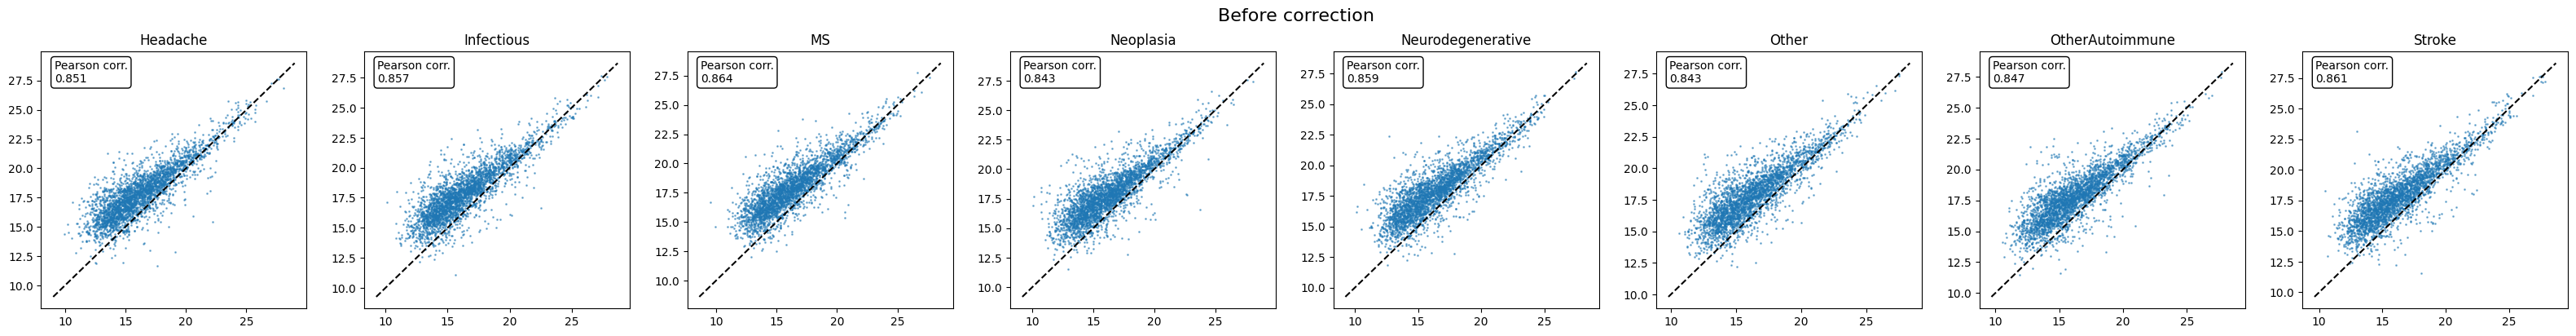

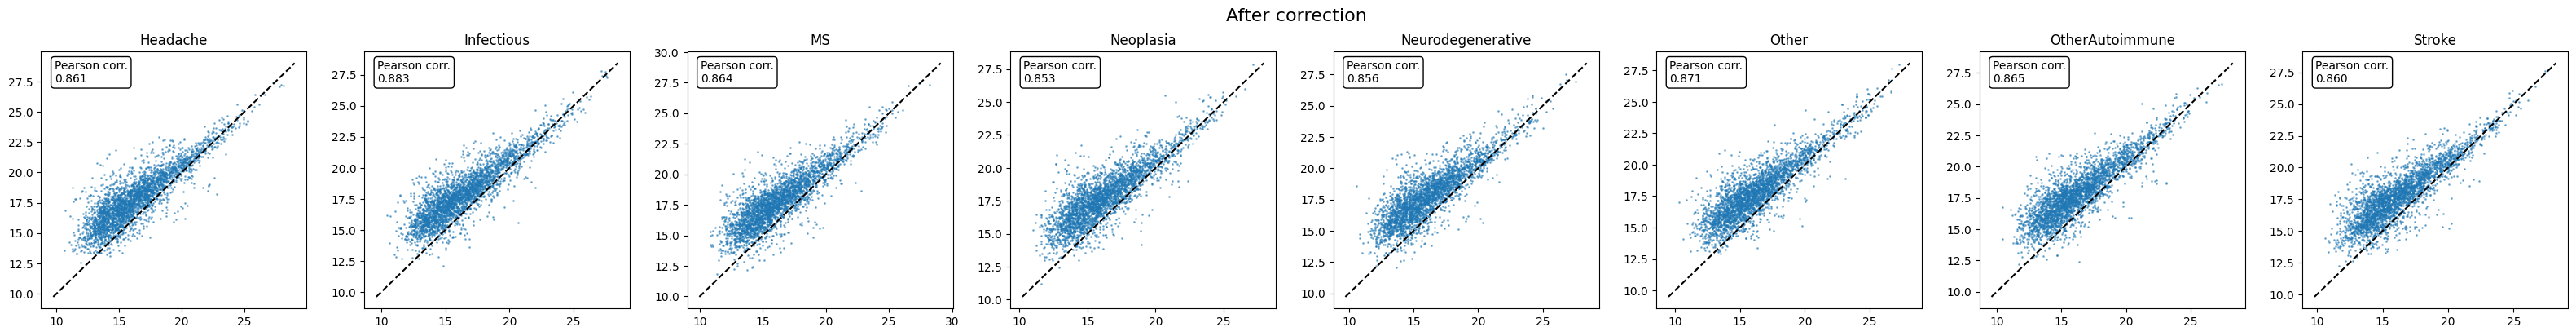

In [8]:
N = 3_000

obs_color_annotation = combined_adata.obs["Diagnosis_group"]

# before batch correction
unique_obs_annotations = np.unique(obs_color_annotation)

fig, axes = plt.subplots(figsize=(4 * len(unique_obs_annotations), 4), ncols=len(unique_obs_annotations))
fig.tight_layout(pad=2)
fig.suptitle("Before correction", fontsize=16, y=1.05)

np.random.seed(0)

for i, annotation in enumerate(unique_obs_annotations):
    ax = axes[i]
    annotation_filter = np.tile(np.array(obs_color_annotation == annotation).reshape(-1, 1), combined_adata.n_vars)
    overlap_filter = np.logical_and(~np.isnan(combined_adata.layers["PILOT"]), ~np.isnan(combined_adata.layers["MAIN"]), annotation_filter)

    intensity_MAIN = combined_adata.layers["MAIN"][overlap_filter]
    intensity_PILOT = combined_adata.layers["PILOT"][overlap_filter]
    
    ns = np.random.choice(np.sum(overlap_filter), size=N)
    intensity_MAIN = intensity_MAIN[ns]
    intensity_PILOT = intensity_PILOT[ns]

    ax.scatter(intensity_MAIN, intensity_PILOT, s=1, alpha=0.5)
    ax.set_title(f"{annotation}")

    pearson = pearsonr(intensity_MAIN, intensity_PILOT)
    ax.text(0.05, 0.88, f"Pearson corr.\n{pearson[0]:.3f}", fontsize=10, bbox=dict(facecolor="white", edgecolor="black", boxstyle="round"), transform=ax.transAxes)

    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x, color="black", linestyle="--")



# after batch correction
fig, axes = plt.subplots(figsize=(4 * len(unique_obs_annotations), 4), ncols=len(unique_obs_annotations))
fig.tight_layout(pad=2)
fig.suptitle("After correction", fontsize=16, y=1.05)

for i, annotation in enumerate(unique_obs_annotations):
    ax = axes[i]
    annotation_filter = np.tile(np.array(obs_color_annotation == annotation).reshape(-1, 1), combined_adata.n_vars)
    overlap_filter = np.logical_and(~np.isnan(combined_adata.layers["PILOT"]), ~np.isnan(combined_adata.layers["MAIN"]), annotation_filter)

    intensity_MAIN = combined_adata.layers["MAIN_corrected"][overlap_filter]
    intensity_PILOT = combined_adata.layers["PILOT_corrected"][overlap_filter]
    
    ns = np.random.choice(np.sum(overlap_filter), size=N)
    intensity_MAIN = intensity_MAIN[ns]
    intensity_PILOT = intensity_PILOT[ns]

    ax.scatter(intensity_MAIN, intensity_PILOT, s=1, alpha=0.5)
    ax.set_title(f"{annotation}")

    pearson = pearsonr(intensity_MAIN, intensity_PILOT)
    ax.text(0.05, 0.88, f"Pearson corr.\n{pearson[0]:.3f}", fontsize=10, bbox=dict(facecolor="white", edgecolor="black", boxstyle="round"), transform=ax.transAxes)

    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x, color="black", linestyle="--")

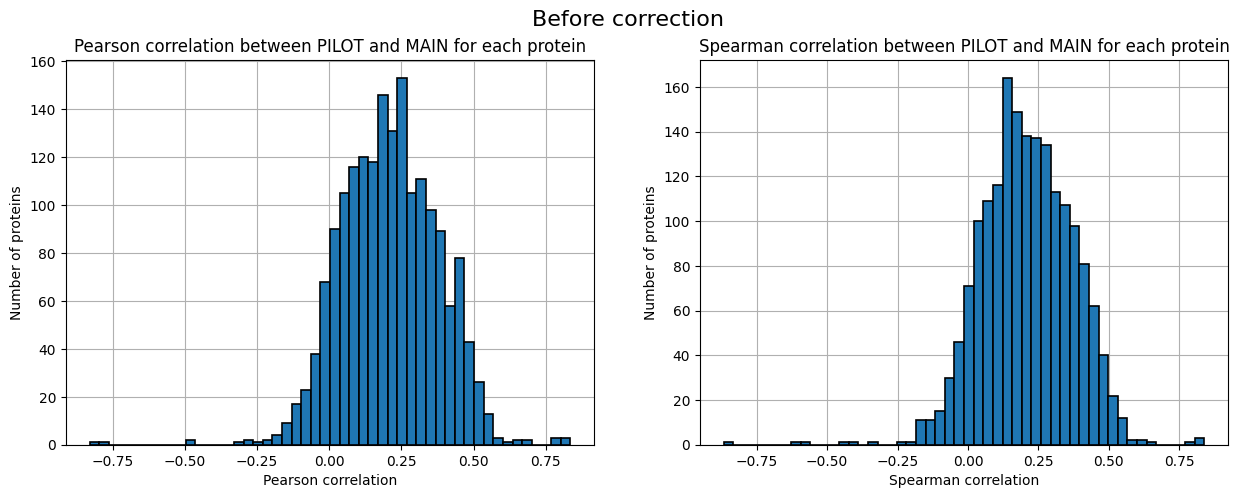

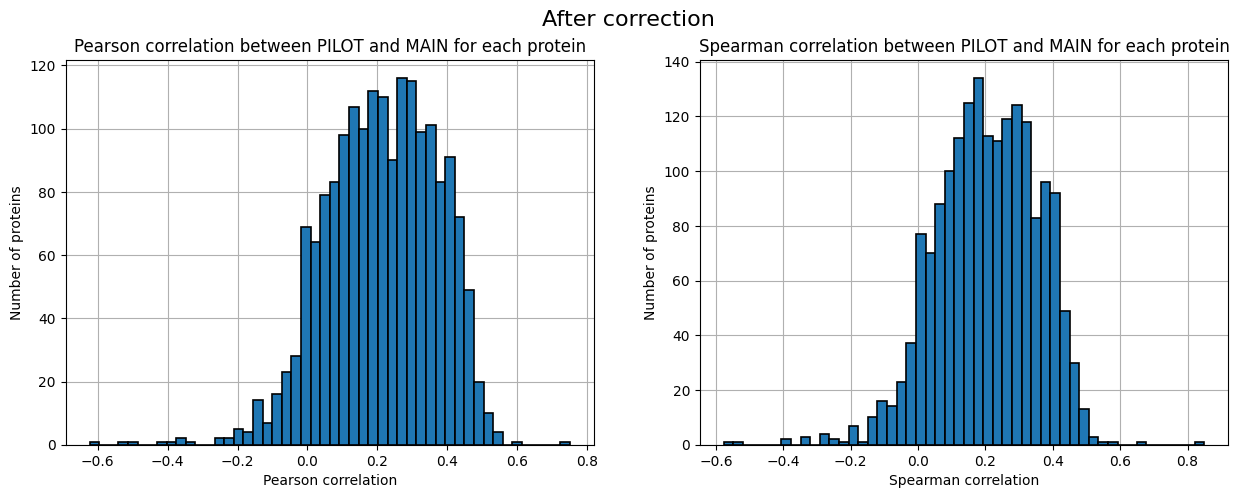

In [9]:
# before batch correction
pearson_correlations = []
spearman_correlations = []

for i in range(combined_adata.n_vars):
    intensity_MAIN = combined_adata.layers["MAIN"][:,i][overlap_filter[:,i]]
    intensity_PILOT = combined_adata.layers["PILOT"][:,i][overlap_filter[:,i]]

    pearson_correlations.append(np.corrcoef(intensity_MAIN, intensity_PILOT)[0, 1])
    spearman_correlations.append(spearmanr(intensity_MAIN, intensity_PILOT)[0])

fig, axes = plt.subplots(figsize=(15, 5), ncols=2)
fig.suptitle("Before correction", fontsize=16)

ax = axes[0]
ax.hist(pearson_correlations, bins=50, edgecolor="black", linewidth=1.2)
ax.set_title("Pearson correlation between PILOT and MAIN for each protein")
ax.set_xlabel("Pearson correlation")
ax.set_ylabel("Number of proteins")
ax.grid(True)
ax.set_axisbelow(True)

ax = axes[1]
ax.hist(spearman_correlations, bins=50, edgecolor="black", linewidth=1.2)
ax.set_title("Spearman correlation between PILOT and MAIN for each protein")
ax.set_xlabel("Spearman correlation")
ax.set_ylabel("Number of proteins")
ax.grid(True)
ax.set_axisbelow(True)

# after batch correction
pearson_correlations = []
spearman_correlations = []

for i in range(combined_adata.n_vars):
    intensity_MAIN = combined_adata.layers["MAIN_corrected"][:,i][overlap_filter[:,i]]
    intensity_PILOT = combined_adata.layers["PILOT_corrected"][:,i][overlap_filter[:,i]]

    pearson_correlations.append(np.corrcoef(intensity_MAIN, intensity_PILOT)[0, 1])
    spearman_correlations.append(spearmanr(intensity_MAIN, intensity_PILOT)[0])

fig, axes = plt.subplots(figsize=(15, 5), ncols=2)
fig.suptitle("After correction", fontsize=16)

ax = axes[0]
ax.hist(pearson_correlations, bins=50, edgecolor="black", linewidth=1.2)
ax.set_title("Pearson correlation between PILOT and MAIN for each protein")
ax.set_xlabel("Pearson correlation")
ax.set_ylabel("Number of proteins")
ax.grid(True)
ax.set_axisbelow(True)

ax = axes[1]
ax.hist(spearman_correlations, bins=50, edgecolor="black", linewidth=1.2)
ax.set_title("Spearman correlation between PILOT and MAIN for each protein")
ax.set_xlabel("Spearman correlation")
ax.set_ylabel("Number of proteins")
ax.grid(True)
ax.set_axisbelow(True)

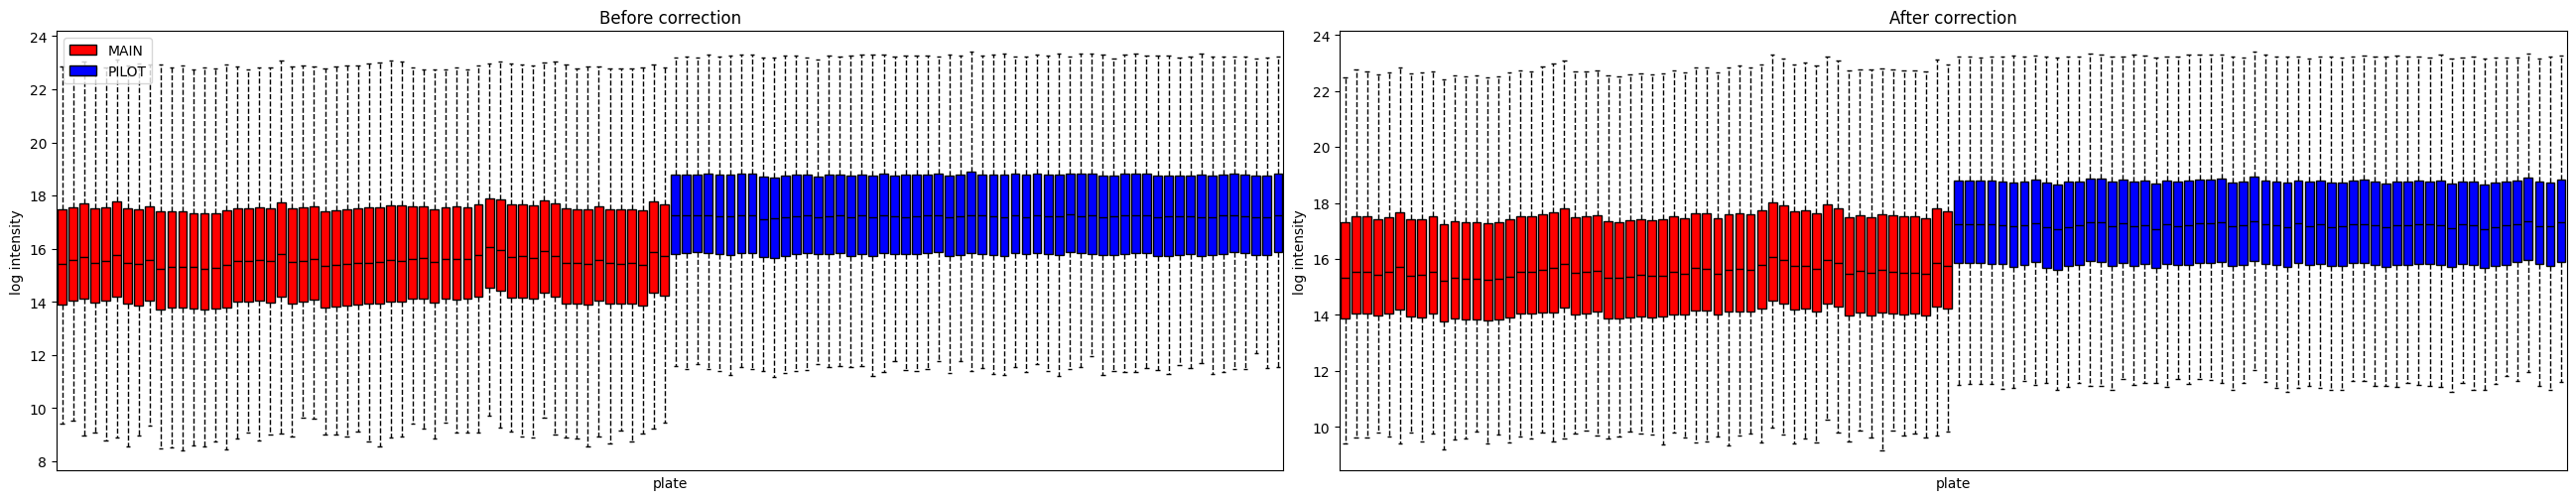

In [10]:
offset = 0

fig, axes = plt.subplots(figsize=(26, 5), ncols=2)
fig.tight_layout(pad=1)

# before
ax = axes[0]
ax.set_xlabel("plate")
ax.set_ylabel("log intensity")
ax.set_title("Before correction")

plates = combined_adata.obs["Plate"].unique()

ax.axes.set_xlim(-0.5 - offset, -0.5 + 2*len(plates) + offset)

for i, plate in enumerate(plates):
    adata_plate = combined_adata[combined_adata.obs["Plate"] == plate]
    intensities = adata_plate.layers["MAIN"][~np.isnan(adata_plate.layers["MAIN"])]

    ax.boxplot(intensities, positions=[i], widths=.8, showfliers=False, patch_artist=True, boxprops=dict(facecolor="red"), medianprops=dict(color="black"),
               whiskerprops=dict(linestyle='--', color="black"), capprops=dict(linestyle='--', color="black"))

position_offset = len(plates)
for i, plate in enumerate(plates):
    adata_plate = combined_adata[combined_adata.obs["Plate"] == plate]
    intensities = adata_plate.layers["PILOT"][~np.isnan(adata_plate.layers["PILOT"])]

    ax.boxplot(intensities, positions=[position_offset + i], widths=.8, showfliers=False, patch_artist=True, boxprops=dict(facecolor="blue"), medianprops=dict(color="black"),
               whiskerprops=dict(linestyle='--', color="black"), capprops=dict(linestyle='--', color="black"))

# after
ax = axes[1]
ax.set_title("After correction")
ax.set_xlabel("plate")
ax.set_ylabel("log intensity")

plates = combined_adata.obs["Plate"].unique()

ax.axes.set_xlim(-0.5 - offset, -0.5 + 2*len(plates) + offset)

for i, plate in enumerate(plates):
    adata_plate = combined_adata[combined_adata.obs["Plate"] == plate]
    intensities = adata_plate.layers["MAIN_corrected"][~np.isnan(adata_plate.layers["MAIN_corrected"])]

    ax.boxplot(intensities, positions=[i], widths=.8, showfliers=False, patch_artist=True, boxprops=dict(facecolor="red"), medianprops=dict(color="black"),
               whiskerprops=dict(linestyle='--', color="black"), capprops=dict(linestyle='--', color="black"))

position_offset = len(plates)
for i, plate in enumerate(plates):
    adata_plate = combined_adata[combined_adata.obs["Plate"] == plate]
    intensities = adata_plate.layers["PILOT_corrected"][~np.isnan(adata_plate.layers["PILOT_corrected"])]

    # used dashed lines
    ax.boxplot(intensities, positions=[position_offset + i], widths=.8, showfliers=False, patch_artist=True, boxprops=dict(facecolor="blue"), medianprops=dict(color="black"),
               whiskerprops=dict(linestyle='--', color="black"), capprops=dict(linestyle='--', color="black"))


# legend
from matplotlib.patches import Patch

for ax in axes:
    ax.xaxis.set_ticklabels([])
    ax.set_xticks([])

legend_elements = [
    Patch(facecolor='red', edgecolor='black', label='MAIN'),
    Patch(facecolor='blue', edgecolor='black', label='PILOT'),
]

axes[0].legend(handles=legend_elements, loc="upper left")

